<h1>
An analysis of 15th General Election of Malaysia</h1>

In [31]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import warnings

In [39]:
data = pd.read_csv("data/voters_ge15.csv")

In [43]:
data[['total', 'total_ge14']].sum()

total         21173638.0
total_ge14    14971678.0
dtype: float64

Charting Voter Turnout and Spoiled/Rejected Votes

In [36]:
def choropleth_gradient(df=None, plot_for=('Malaysia'), v='spoiled_or_rejected_votes'):

    v_suffix = {'peratus_keluar': 'turnout',
                'spoiled_or_rejected_votes': 'spoiled or rejected votes'}

    v_title = {'peratus_keluar': 'Voter Turnout',
               'spoiled_or_rejected_votes': 'Spoiled or Rejected Votes (% of votes)'}

    cmaps = {'peratus_keluar': 'Blues',
             'spoiled_or_rejected_votes': 'Reds'}


    path_output = f'charts-{v_suffix[v]}'
    if not os.path.isdir(path_output):
        os.makedirs(path_output)

    for s in plot_for:
        print(s)
        geo = df.copy()
        title = ''
        suffix = ''
        if s != 'Malaysia':
            geo = geo[geo.state == s]
            title = f' in {s}'
            suffix = '_' + s.lower().replace(' ', '').replace('.', '')

        geo_s = geo.copy().dissolve(by='state')

        plt.rcParams.update({'font.size': 13,
                            'font.family': 'sans-serif',
                             'grid.linestyle': 'dotted',
                             'figure.figsize': [8, 8],
                             'figure.autolayout': True})
        fig, ax = plt.subplots()
        ax.axis('off')

        cmap = cmaps[v]
        lw = 1 if s != 'Malaysia' else 0.7
        vmin, vmax = geo[v].min(), geo[v].max()  # colours relative to specific range being plotted

        geo.plot(column=v, cmap=cmap, vmin=vmin, vmax=vmax, linewidth=0.07, edgecolor='black', ax=ax)
        geo_s.plot(edgecolor='black', linewidth=lw, facecolor='none', ax=ax)
        if s != 'Malaysia':
            bbox_props = dict(boxstyle='round', fc="w", ec='0.5', alpha=0.5)
            geo.apply(lambda x: ax.annotate(text=x['seat'][6:],
                                            xy=x.geometry.centroid.coords[0],
                                            ha='center', va='center',
                                            size=9, bbox=bbox_props,
                                            wrap=True), axis=1)
        cbar_ax = fig.add_axes([0.1, 0.00, 0.8, 0.01])
        cbar = fig.colorbar(
            plt.cm.ScalarMappable(
                cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)
            ), cax=cbar_ax, orientation="horizontal")

        plt.suptitle(f'GE15: {v_title[v]} by Parliament{title}')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            plt.savefig(f'{path_output}/choropleth_{v_suffix[v]}{suffix}.png',
                        bbox_inches='tight', pad_inches=0.2, dpi=400)
        plt.show()


In [33]:
df = pd.read_csv('data/results_parlimen_ge15.csv')
df['majoriti_peratus'] = df.majoriti/df.undi_keluar_peti * 100
df['spoiled_or_rejected_votes'] = (df['undi_rosak'] + df['undi_tolak']) / df['undi_dalam_peti']
geo_o = gpd.read_file('maps/parlimen.geojson')
geo_o.loc[~geo_o.code_state.isin([12, 13, 15]), 'geometry'] = geo_o.geometry.translate(9, 4.5)  # More compact Msia map
geo_o = pd.merge(geo_o, df,
                 left_on=['state', 'parlimen'],
                 right_on=['state', 'parlimen'], how='left')  # Merge with election results

In [34]:
choropleth_gradient(df=geo_o)

Malaysia


Malaysia


<Figure size 800x800 with 0 Axes>

c:\users\admin\desktop\km\analysis-election-msia\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


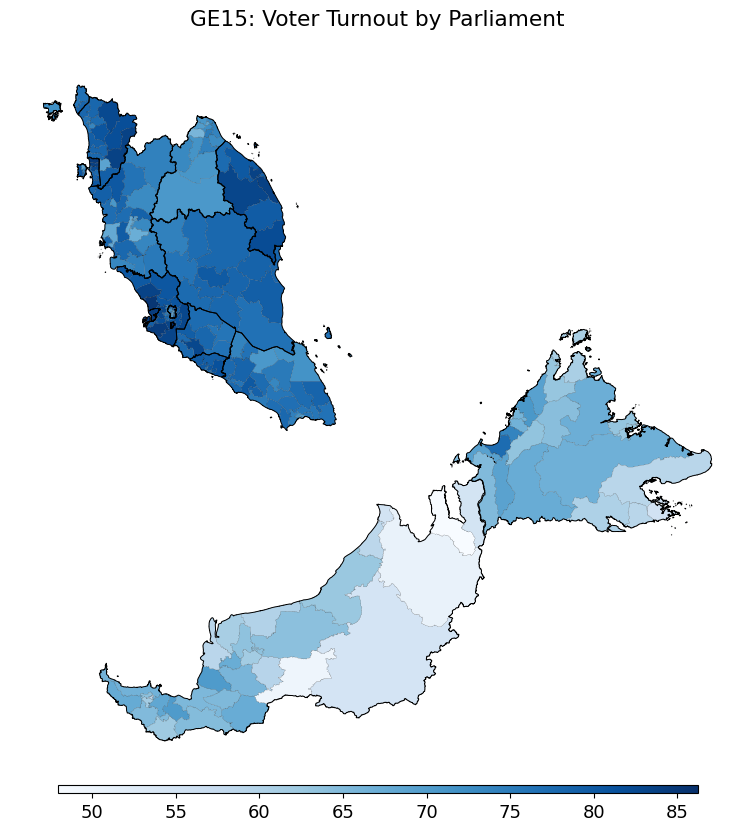

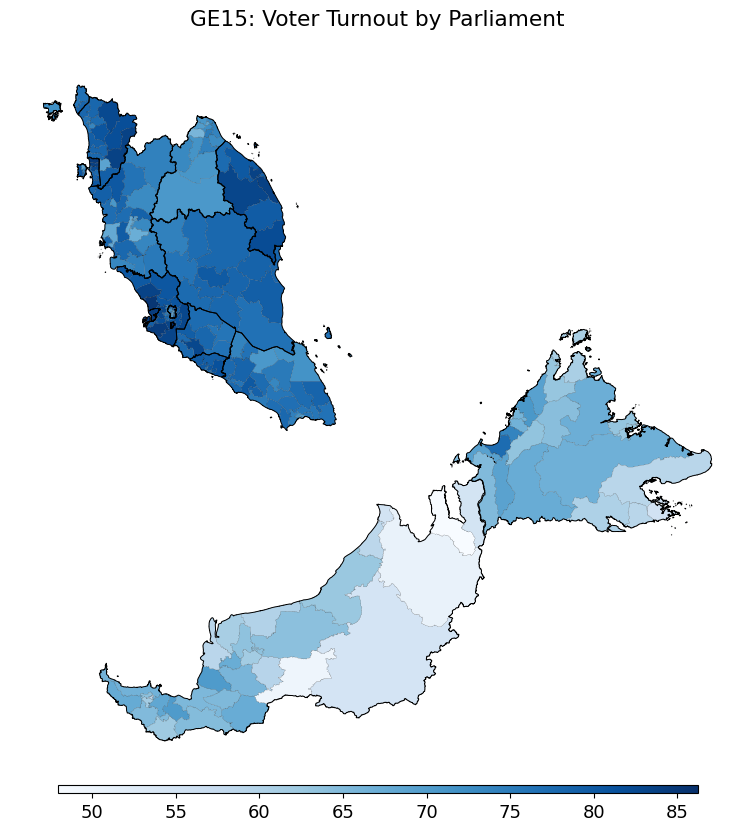

In [37]:
choropleth_gradient(df=geo_o, v='peratus_keluar')

Cleaning CSV Data regarding GE_15 Candidates

In [20]:
party_replace = {
    'PARTI KEADILAN RAKYAT (PKR)': 'PAKATAN HARAPAN (PH)',
    'PARTI TINDAKAN DEMOKRATIK (DAP)': 'PAKATAN HARAPAN (PH)',
    'PARTI ISLAM SE MALAYSIA (PAS)': 'PERIKATAN NASIONAL (PN)',
    'IKATAN DEMOKRATIK MALAYSIA (MUDA)': 'PAKATAN HARAPAN (PH)'
}

df = pd.read_csv('data/candidates_ge15.csv',usecols=['state','parlimen','party','result'])
df.party = df.party.replace(party_replace).fillna(df.party)
df = df[df.result == 1].drop('result',axis=1)
n_seats = df[['party']].groupby('party').size()
# df = df[~df.state.isin(['Sabah','Sarawak','W.P. Labuan'])] # to add East Msia, comment out this line
df.party = df.party.map(party_replace).fillna(df.party)
df['party_short'] = df.party.str.extract(r'\((\w+)\)')
party_abbr = dict(zip(df.party,df.party_short))
df = df.drop('party_short',axis=1)

vf = pd.read_csv('data/voters_ge15.csv',usecols=['state','parlimen','total']).rename(columns={'total':'voters'}).groupby(['state','parlimen']).sum().reset_index()

df = pd.merge(df,vf,on=['state','parlimen'],how='left')
assert len(df[df.voters.isnull()]) == 0, 'Missing data!' # ensure complete merge
n_voters = (df[['party','voters']].groupby('party').mean()).to_dict()

df = df.sort_values(by='voters',ascending=False).reset_index(drop=True)

df.to_csv("parlimen.csv")

Collecting data to chart Prime Minister Age

c:\users\admin\desktop\km\analysis-election-msia\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


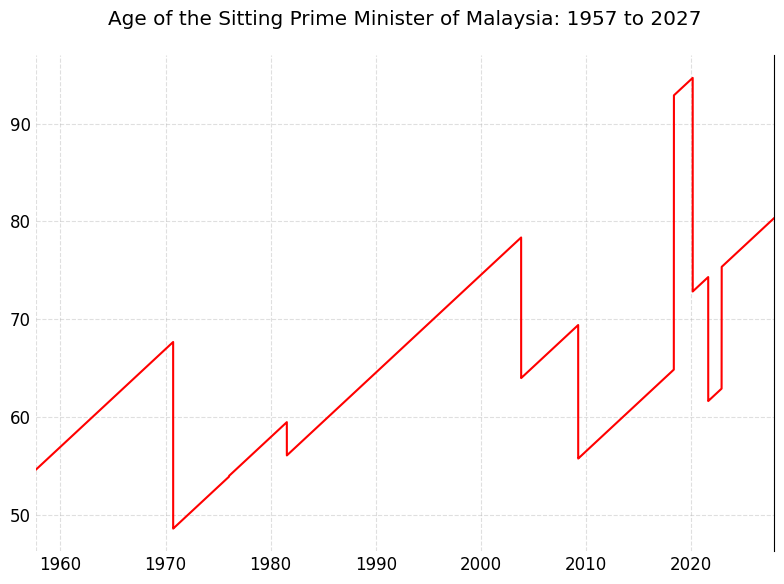

In [13]:
import pandas as pd
from datetime import timedelta

data = [
    ['1957-08-31',''],
    ['1970-09-22','1903-02-08'],
    ['1976-01-14','1922-03-11'],
    ['1981-07-16','1922-02-12'],
    ['2003-10-30','1925-07-10'],
    ['2009-04-03','1939-11-26'],
    ['2018-05-09','1953-07-23'],
    ['2020-02-24','1925-07-10'],
    ['2021-08-16','1947-05-15'],
    ['2022-11-24','1960-01-18'],
    ['2027-11-19','1947-08-10']
]

tf = pd.DataFrame(data,columns=['date','birthday'])
for c in tf.columns: tf[c] = pd.to_datetime(tf[c]).dt.date

sdate,edate = tf.date.iloc[0], tf.date.iloc[-1] + timedelta(1)
df = pd.DataFrame(columns=['date'])
df.date = [sdate + timedelta(x) for x in range((edate-sdate).days)]

df = pd.merge(df,tf,on='date',how='left').bfill()
for c in df.columns: df[c] = pd.to_datetime(df[c])
df['age'] = (df.date-df.birthday).dt.days/365
df = df.set_index('date')

darkmode = 0

if darkmode == 0:
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 12,
                        'font.family': 'sans-serif',
                        'grid.linestyle': 'dashed',
                        'figure.autolayout': True,
                        'figure.figsize': [8,6]})
    fig, ax = plt.subplots(facecolor='white')

    df['age'].plot(ax=ax, color='red')
    for p in ['top','bottom','left']: ax.spines[p].set_visible(False)
    ax.set_xlabel('')
    ax.yaxis.grid(True, alpha=0.4)
    ax.xaxis.grid(True, alpha=0.4)
    ax.tick_params(axis=u'both', which=u'both',length=0, colors='black')
    ax.set_title('Age of the Sitting Prime Minister of Malaysia: 1957 to 2027\n', color='black')
    plt.show()
else:
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 12,
                        'font.family': 'sans-serif',
                        'grid.linestyle': 'dashed',
                        'figure.autolayout': True,
                        'figure.figsize': [8,6]})
    fig, ax = plt.subplots(facecolor='black')

    df['age'].plot(ax=ax, color='blue')
    ax.set_xlabel('')
    # for p in ['top','bottom','right','left']: ax.spines[p].set_visible(False)
    ax.yaxis.grid(True, alpha=0.4)
    ax.xaxis.grid(True, alpha=0.4)
    ax.set_facecolor('black')
    ax.tick_params(axis=u'both', which=u'both',length=0, colors='white')
    ax.set_title('Age of the Sitting Prime Minister of Malaysia: 1957 to 2027\n', color='white')
    plt.show()

In [ ]:
df['age'].to_csv("pm_age.csv")